In [1]:
import os
import random

import numpy as np
import pandas as pd
import pdb
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '/scratch/vr1059/self-driving-data/data'
annotation_csv = '/scratch/vr1059/self-driving-data/data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
train_labeled_scene_index = np.arange(106, 130)
val_labeled_scene_index = np.arange(130, 134)

In [2]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

### Dataset

In [37]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
transform = torchvision.transforms.ToTensor()
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )

def front_collate_fn(batch):
    front_imgs = []
    front_right_imgs = []
    front_left_imgs = []
    target = []
    road_imgs = []
    bbs = []
    for x in batch:
        # input
        front_left_imgs.append(torch.tensor(x[0][0]))
        front_imgs.append(torch.tensor(x[0][1]))
        front_right_imgs.append(torch.tensor(x[0][2]))
        road_imgs.append(torch.tensor(x[2]))
        
        # target
        bb_tens = x[1]['bounding_box']
        bbs.append(bb_tens)
        x_min = 800
        bb_cand = (-500, -500, 0)
        
        for i, corners in enumerate(bb_tens):
            # Get bird's eye view coordinates. 
            point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2]])
            xs = point_squence.T[0] * 10 + 400
            ys = -point_squence.T[1] * 10 + 400
            if xs[2] - xs[0] > 5:
                top_center_x, top_center_y = 0.5*(xs[2] + xs[3]), 0.5*(ys[2] + ys[3])
            else:
                top_center_x, top_center_y = 0.5*(xs[0] + xs[1]), 0.5*(ys[0] + ys[1])
                
            v1 = np.array([top_center_x - 400, 800 - top_center_y - 400])
            v2 = np.array([2, 0])
            
            if abs(angle_between(v1, v2)) <= 35 and x[1]['category'][i] not in [1, 3, 6, 8]:
                if top_center_x < x_min:
                    x_min = top_center_x
                    bb_cand = (top_center_x.item(), top_center_y.item(), 1)
                
        target.append(bb_cand)
                    
    boom = torch.stack(front_imgs), torch.tensor(target), torch.stack(road_imgs), bbs, torch.stack(front_right_imgs), torch.stack(front_left_imgs)
    return boom

train_loader = torch.utils.data.DataLoader(labeled_trainset, batch_size=20, shuffle=True, collate_fn=front_collate_fn)
val_loader = torch.utils.data.DataLoader(labeled_valset, batch_size=20, shuffle=False, collate_fn=front_collate_fn)


In [38]:
boom = torch.randn(2, 512)
nn.BatchNorm1d(512)(boom).shape

torch.Size([2, 512])

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        
        self.encoder = torchvision.models.resnet18()
        self.encoder.fc = nn.Identity()
        
        self.regression = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(512, 2))
        ]))
        
#         self.regression.linear1.bias = nn.Parameter(torch.tensor(400.))
        
    def forward(self, x):
        x = self.encoder(x)
        return self.regression(x)
    
model = SimpleModel().to(device)

### Train

In [40]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epoch = 0

model.train()
for epoch in range(3):
    for i, (sample, target, road_img, bbs, front_right, front_left) in enumerate(train_loader):

        optimizer.zero_grad()

        sample = sample.to(device)
        target = target.to(device)

        target = target/100.

        y_hat = model(sample)
        target = target[:, :2]
        loss = criterion(y_hat, target)

        loss.backward()
        optimizer.step()

        if i % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(sample), len(train_loader.dataset),
                5. * i / len(train_loader), loss.item()))
    
    

/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTe

Train Epoch: 0 [0/3024 (0%)]	Loss: 25.002306
Train Epoch: 0 [100/3024 (0%)]	Loss: 20.231821
Train Epoch: 0 [200/3024 (0%)]	Loss: 15.297869
Train Epoch: 0 [300/3024 (0%)]	Loss: 10.568732
Train Epoch: 0 [400/3024 (1%)]	Loss: 12.701372
Train Epoch: 0 [500/3024 (1%)]	Loss: 8.934168
Train Epoch: 0 [600/3024 (1%)]	Loss: 8.488668
Train Epoch: 0 [700/3024 (1%)]	Loss: 6.477527
Train Epoch: 0 [800/3024 (1%)]	Loss: 5.490826
Train Epoch: 0 [900/3024 (1%)]	Loss: 12.129835
Train Epoch: 0 [1000/3024 (2%)]	Loss: 5.876660
Train Epoch: 0 [1100/3024 (2%)]	Loss: 6.645523
Train Epoch: 0 [1200/3024 (2%)]	Loss: 6.584925
Train Epoch: 0 [1300/3024 (2%)]	Loss: 3.572299
Train Epoch: 0 [1400/3024 (2%)]	Loss: 7.715407
Train Epoch: 0 [1500/3024 (2%)]	Loss: 5.189019
Train Epoch: 0 [1600/3024 (3%)]	Loss: 7.481452
Train Epoch: 0 [1700/3024 (3%)]	Loss: 3.740819
Train Epoch: 0 [1800/3024 (3%)]	Loss: 8.888045
Train Epoch: 0 [1900/3024 (3%)]	Loss: 5.501157
Train Epoch: 0 [2000/3024 (3%)]	Loss: 3.442427
Train Epoch: 0 [210

In [43]:
val_losses = []
for i, (sample, target, road_img, bbs, front_right, front_left) in enumerate(val_loader):
    
    model.eval()
    
    sample = sample.to(device)
    target = target.to(device)
    
    with torch.no_grad():
        target = target/100.

        y_hat = model(sample)
        target = target[:, :2]
        loss = criterion(y_hat, target)
        
        val_losses.append(loss.item())
    
    if i % 5 == 0:
        print('Val Epoch: {} [{}/{} ({:.0f}%)]\tAverage Loss So Far: {:.6f}'.format(
            epoch, i * len(sample), len(val_loader.dataset),
            5. * i / len(val_loader), np.mean(val_losses)))

/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTe

Val Epoch: 2 [0/504 (0%)]	Average Loss So Far: 3.026171
Val Epoch: 2 [100/504 (1%)]	Average Loss So Far: 6.151769
Val Epoch: 2 [200/504 (2%)]	Average Loss So Far: 5.981733
Val Epoch: 2 [300/504 (3%)]	Average Loss So Far: 5.637507
Val Epoch: 2 [400/504 (4%)]	Average Loss So Far: 5.176090
Val Epoch: 2 [100/504 (5%)]	Average Loss So Far: 5.843478


In [41]:
val_loader = torch.utils.data.DataLoader(labeled_valset, batch_size=20, shuffle=True, collate_fn=front_collate_fn)
sample, target, road_img, bbs, front_right, front_left = iter(val_loader).next()
sample = sample.to(device)
target = target.to(device)
model.eval()
target/100.

/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTe

tensor([[5.5625, 4.2185, 0.0100],
        [5.3336, 3.6511, 0.0100],
        [6.5161, 4.2575, 0.0100],
        [5.9827, 3.4632, 0.0100],
        [5.9157, 3.6298, 0.0100],
        [5.5361, 3.3032, 0.0100],
        [6.1867, 3.5874, 0.0100],
        [5.9150, 3.6440, 0.0100],
        [4.6766, 3.6201, 0.0100],
        [5.4582, 4.9263, 0.0100],
        [6.1962, 2.9319, 0.0100],
        [6.9358, 3.2888, 0.0100],
        [5.4012, 4.3544, 0.0100],
        [6.0738, 5.3195, 0.0100],
        [4.6716, 4.3237, 0.0100],
        [6.7109, 5.1519, 0.0100],
        [5.6806, 4.9310, 0.0100],
        [5.9489, 3.2650, 0.0100],
        [4.7274, 3.6543, 0.0100],
        [5.3496, 4.3440, 0.0100]], device='cuda:0')

In [42]:
model(sample)

tensor([[5.6962, 3.9174],
        [3.8656, 2.2779],
        [6.1284, 3.6897],
        [5.9971, 3.4591],
        [3.8432, 1.2146],
        [1.8187, 0.6622],
        [5.9601, 3.4475],
        [4.2081, 1.5048],
        [3.8562, 3.2257],
        [5.0524, 2.7303],
        [5.0460, 1.8975],
        [3.2892, 1.6770],
        [5.2988, 3.6290],
        [5.8153, 2.9481],
        [2.9357, 2.7960],
        [5.2196, 2.3476],
        [6.0228, 3.4470],
        [4.9415, 2.0337],
        [3.5569, 3.3208],
        [3.2589, 3.0076]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
sample, target, road_img, bbs, front_right, front_left = iter(train_loader).next()

In [9]:
sample.shape

torch.Size([20, 3, 256, 306])

In [10]:
target

tensor([[ 460.1010,  362.4556,    1.0000],
        [ 468.5497,  435.1026,    1.0000],
        [ 563.7537,  441.0834,    1.0000],
        [ 547.6623,  368.7265,    1.0000],
        [ 470.5904,  431.7527,    1.0000],
        [ 457.6465,  432.6031,    1.0000],
        [ 528.4179,  324.4542,    1.0000],
        [ 461.1741,  436.8524,    1.0000],
        [ 726.6880,  370.1960,    1.0000],
        [-100.0000, -100.0000,    0.0000],
        [ 577.0494,  373.1374,    1.0000],
        [ 486.6564,  435.2869,    1.0000],
        [ 568.2909,  364.5506,    1.0000],
        [ 509.9270,  438.1136,    1.0000],
        [-100.0000, -100.0000,    0.0000],
        [ 498.9967,  363.9543,    1.0000],
        [ 471.3078,  433.4042,    1.0000],
        [ 634.8564,  402.4367,    1.0000],
        [ 517.9758,  428.6368,    1.0000],
        [ 569.5204,  366.1638,    1.0000]])

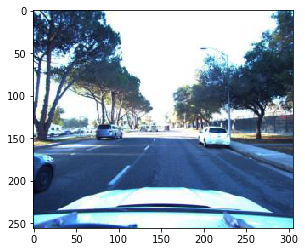

In [11]:
idx = 0
plt.imshow(sample[idx][:, :, :].numpy().transpose(1, 2, 0))
# plt.imshow(front_right[idx][:, :, :].numpy().transpose(1, 2, 0))

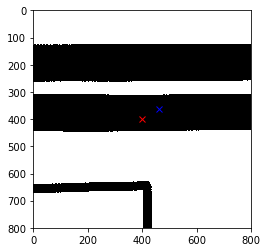

In [12]:
fig, ax = plt.subplots()
ax.imshow(road_img[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")
ax.plot(target[idx][0], target[idx][1], 'x', color="blue")